In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import tensorflow.keras.models as models

In [2]:
img = Image.open("./Data/Sentinel1_Image_20221202_Small.png")
img.size

(2711, 1836)

### 📖Draw into images
We will use an downsampled image to take a look at the Draw functions, as Jupyter Notebooks does not like the very big image that we just loaded

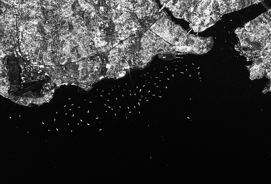

In [3]:
img_small = img.resize((271, 184)).convert("RGB")
img_small

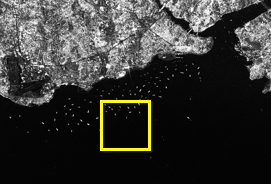

In [4]:
#Turn into an image in which we can draw something
draw = ImageDraw.Draw(img_small)

coordinates = [
    (100,100),
    (150,150)
]
draw.rectangle(coordinates, outline="yellow", width=3)
img_small

### 📖Crop images

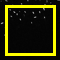

In [5]:
img_crop= img_small.crop((95,95, 155,155))
img_crop

### 📖Turn image into array

In [6]:
i = np.asarray(img_crop)
i.shape

(60, 60, 3)

***
### 📖Search the image for ships

In [7]:
model = models.load_model("./Ship_Detection_Modell.h5") 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0

### 📖Loop over rows and columns
to crop a 64x64 patch out of the image and push it into the model

In [14]:
patch_size = 64
step_size = 32  #When coming to cropping patches test with step_size of 1000 to plot images
width = img.size[0]
height = img.size[1]


for x in range(0, width, step_size): #Go through the x coordinates of our image
    if x + patch_size > width:
        x = width - patch_size
    
    print(x)

    if x == width - patch_size:
        break

    
    #for y in range(0, img.size[1] - size, step_size): #Go through the y coordinates of our image
    #    print(x, y)


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2647


In [19]:
patch_size = 64
step_size = 32  #When coming to cropping patches test with step_size of 1000 to plot images
width = img.size[0]
height = img.size[1]

ships = [] #This list will store the coordinates of the patches with a potential ship

for x in range(0, width , step_size): #Go through the x coordinates of our image
    if x + patch_size > width:
        x = width - patch_size
    
    for y in range(0, height, step_size): #Go through the y coordinates of our image
        if y + patch_size > height:
            y = height - patch_size

        patch = img.crop((x,y, x+patch_size, y+patch_size))
        
        patch = np.array(patch)[:,:,:1] #Turn image into numpy array and select the first band
        #patch = patch.astype(np.float32) 
        patch = patch.reshape(-1, patch_size,patch_size,1) #Make the array suitable for the model
        #print(patch.shape)
        
        #Do the actual prediction
        pred = model.predict(patch)
        #print(pred)
        #Draw rectangle into image, if CNN finds a ship with a certain probability
        if pred[0,0] > 0.99:
            #print(pred)
            ships.append((x,y))
        if y == height - patch_size:
            break
    
    if x == width - patch_size:
        break

1/1 [==============================] - 0s 34ms/step


In [20]:
print(f"Found {len(ships)} potential ships")

Found 91 potential ships


### 📖Highlight all potential ships in the image

In [22]:
img_copy = img.copy()
img_draw = ImageDraw.Draw(img_copy)

for position in ships:
    #print(ship)
    
    coordinate = [
        position,
        (position[0]+patch_size,  position[1]+patch_size)
    ]
    
    img_draw.rectangle(coordinate, outline="yellow", width=3)



img_copy.save("./Detected_Ships.png")

### 📖More efficient way to execute the search

In [38]:
import numpy as np
import tensorflow as tf

def sliding_window(image, window_size, stride):
    """Generate sliding windows for an image."""
    for y in range(0, image.shape[0], stride):
        if y + window_size > image.shape[0]:
            y = image.shape[0] - window_size
        for x in range(0, image.shape[1], stride):
            if x + window_size > image.shape[1]:
                x = image.shape[1] - window_size
            yield x, y, image[y:y + window_size, x:x + window_size, :][:,:,:1]

            if x == image.shape[1] - window_size:
                break

        if y == image.shape[0] - window_size:
            break

def deploy_cnn_with_sliding_window(model, image, window_size=64, stride=32, batch_size=32, threshold=0.99):
    positions = []
    windows = []
    coords = []

    # Gather windows and coordinates
    for x, y, window  in sliding_window(image, window_size, stride):
        windows.append(window)
        coords.append((x, y))
        if len(windows) == batch_size:
            # Batch predict
            predictions = model.predict(np.array(windows))
            for idx, prediction in enumerate(predictions):
                if prediction.max() > threshold:
                    positions.append(coords[idx])
            windows.clear()
            coords.clear()

    # Process any remaining windows
    if windows:
        predictions = model.predict(np.array(windows))
        for idx, prediction in enumerate(predictions):
            if prediction.max() > threshold:
                positions.append(coords[idx])
                
    return positions


In [39]:
size = 64
image = np.asarray(img)
print(image.shape)
ships = deploy_cnn_with_sliding_window(model, image, window_size=size, stride=32, batch_size=128, threshold=0.99)
print(f"Found {len(ships)} potential ships")

img_copy = img.copy()
img_draw = ImageDraw.Draw(img_copy)

for ship in ships:
    #print(ship)
    
    coordinate = [
        ship,
        (ship[0]+size,  ship[1]+size)
    ]
    
    img_draw.rectangle(coordinate, outline="yellow", width=3)
img_copy.save("./Detected_Ships_FastSearch.png")

(1836, 2711, 4)
(0, 0, array([[[144],
        [185],
        [128],
        ...,
        [143],
        [107],
        [ 96]],

       [[138],
        [183],
        [144],
        ...,
        [ 89],
        [125],
        [176]],

       [[111],
        [124],
        [114],
        ...,
        [102],
        [163],
        [255]],

       ...,

       [[ 45],
        [ 41],
        [ 37],
        ...,
        [ 81],
        [ 94],
        [131]],

       [[ 36],
        [ 45],
        [ 49],
        ...,
        [ 55],
        [ 70],
        [ 91]],

       [[ 29],
        [ 27],
        [ 32],
        ...,
        [ 52],
        [ 57],
        [ 74]]], dtype=uint8))


NameError: name 'window' is not defined